In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data

In [2]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data, train_test=False)

# train/test split
df_train = pd.read_csv('../../data/train.csv')
x_train, y_train = separate_data(df_train)
df_test = pd.read_csv('../../data/test.csv')
x_test, y_test = separate_data(df_test)

# get date for x-axis in plots
def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)

2022-08-01 18:20:30.320170: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-01 18:20:31.912391: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


# Simple one-latent function model

        y = f(x) + e
        f = GP(0, RBF)

In [31]:
# function to plot results

def plot_distribution(X, Y, mean, var, pos, labels):
    plt.figure(figsize=(25, 7))

    plt.plot(X, Y, '.', color="black", alpha=0.5, markersize=3)
    plt.plot(X, mean, color="C0")
    c = 1.96 * np.sqrt(var)
    plt.fill_between(X[:,0], (mean - c)[:,0], (mean + c)[:,0], alpha=0.2, edgecolor='gray', facecolor='C0')

    plt.xticks(pos, labels)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Normalised Births', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()
    plt.close()

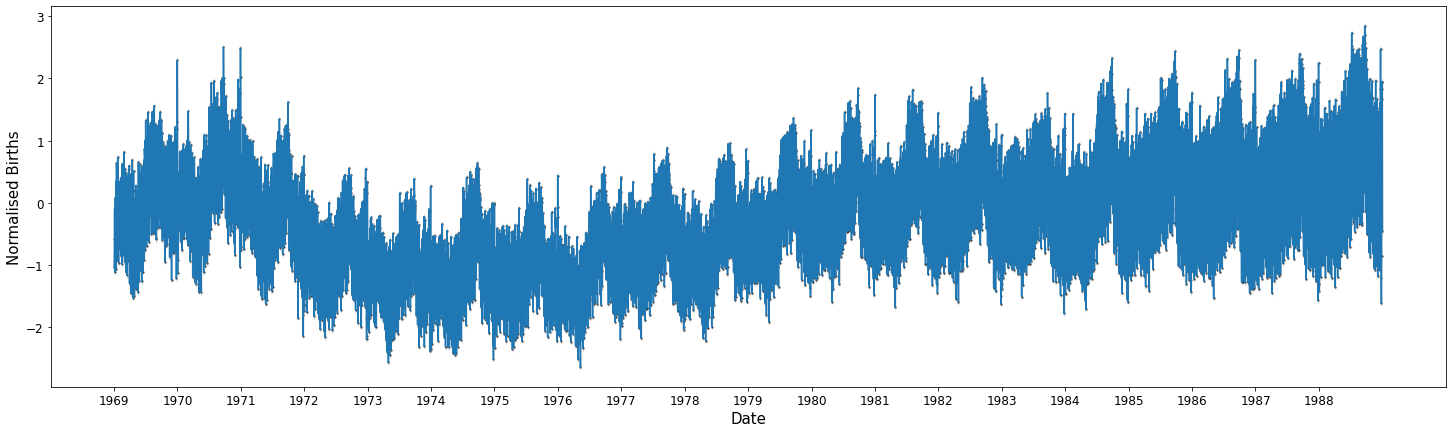

Fitted values MSE:  17789803.11955494
Log-marginal likelihood:  -7832.24926461639


In [37]:
# build model & compute fitted values

kernel = gpflow.kernels.RBF()

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_f(x)

plot_distribution(x, y, mean, var, pos, labels)

print('Fitted values MSE: ', mean_squared_error(x, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())

print_summary(model, fmt='notebook')

The above model uses a GP with RBF kernel. The data is normalised but we still train the noise variance. We have perfect interpolation ie the posterior variance is 0. This is not what we want.

Next we try the same model but set the noise variance to 1 and untrainable.

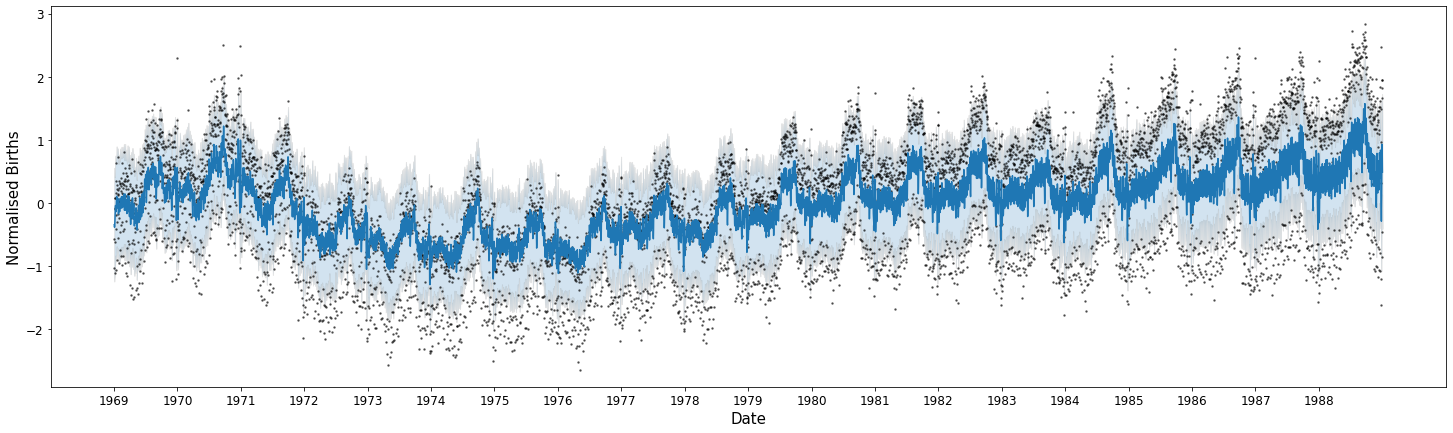

Fitted values MSE:  17790293.527970184
Log-marginal likelihood:  -9778.918001179252


In [6]:
# build model & compute fitted values

kernel = gpflow.kernels.RBF()

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
set_trainable(model.likelihood.variance , False)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_f(x)

plot_distribution(x, y, mean, var, pos, labels)

print('Fitted values MSE: ', mean_squared_error(x, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())

print_summary(model, fmt='notebook')

We are not overfitting as much. The GP captures the overall trend. Possibly the long term behaviour of the data. But it remains in the middle of the two observable trends (weekend and weekday births). The CI is also not good enough(?)

Add priors to penalised small length scales. 

! First, without learning the noise variance 

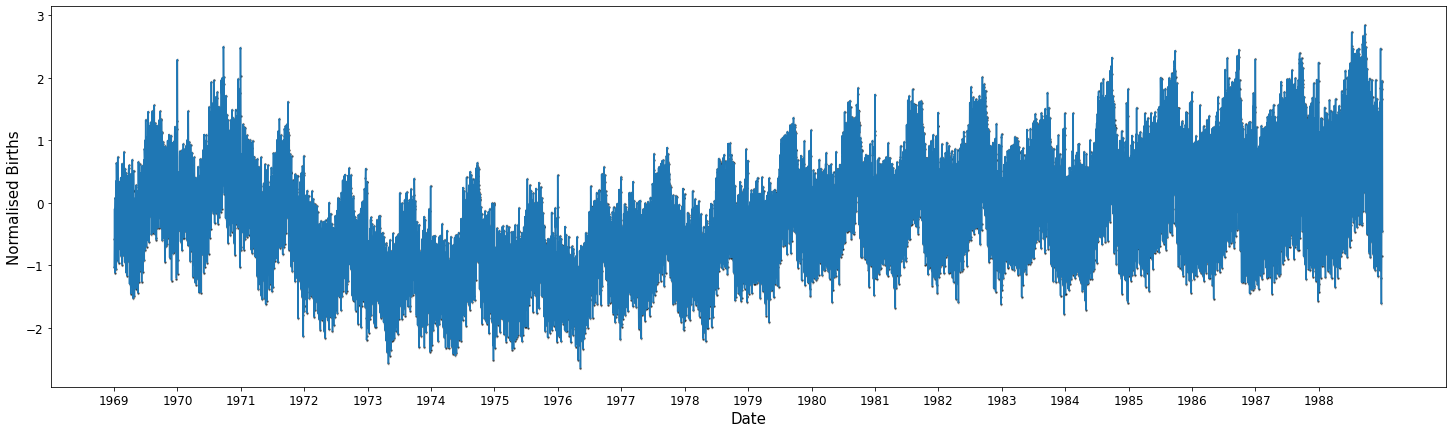

Fitted values MSE:  17789802.984368507
Log-marginal likelihood:  -7832.24940618396


In [7]:
# rebuild model and add prior to hyperparameters

kernel = gpflow.kernels.RBF()

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)

# adding priors
model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_f(x)

plot_distribution(x, y, mean, var, pos, labels)

print('Fitted values MSE: ', mean_squared_error(x, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())

print_summary(model, fmt='notebook')

Again overfitting... Because of the noise variance being trained, it is almost zero after optimisation.

Let's not train it again but still use priors to regularise the choice of hyperparmeters.

! Now, not training noise variance

Optimisation Results:        fun: 9780.385115063702
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.11656545e-03, -5.15364067e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 18
      nit: 9
     njev: 18
   status: 0
  success: True
        x: array([ 2.1190259 , -0.78538783])


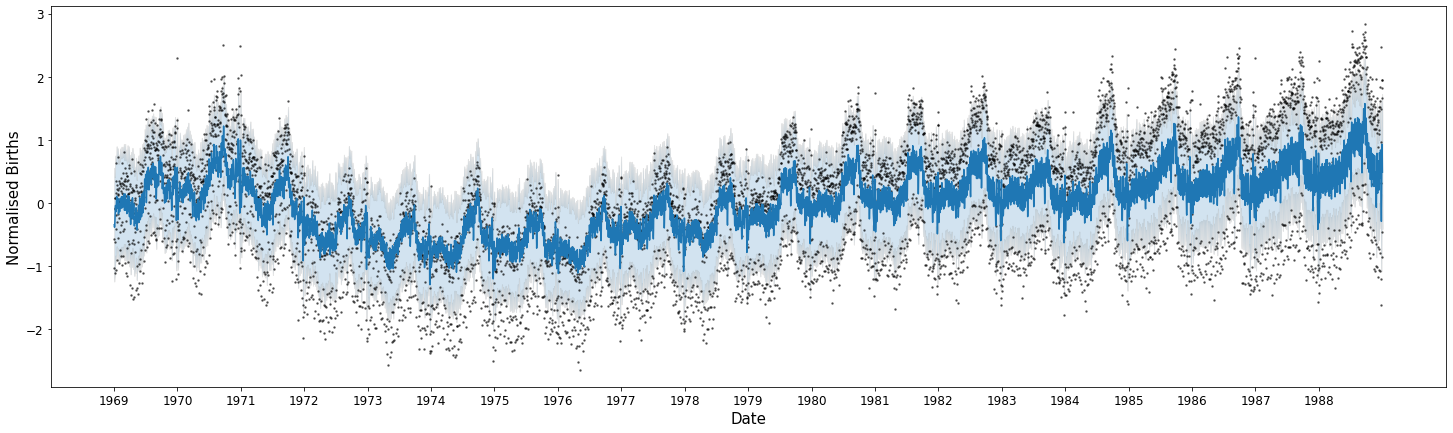

Fitted values MSE:  17790294.068293378
Log-marginal likelihood:  -9778.920373905365


In [42]:
# rebuild model with priors but don't train noise variance

kernel = gpflow.kernels.RBF()

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
set_trainable(model.likelihood.variance , False)

# adding priors
model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)
#print('Optimisation Results: ', opt_logs)

mean, var = model.predict_f(x)

plot_distribution(x, y, mean, var, pos, labels)

print('Fitted values MSE: ', mean_squared_error(x, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())

print_summary(model, fmt='notebook')

It is exactly the same as with no priors WTF !?!

Try different priors but setting the noise variance to not trainable all the time.

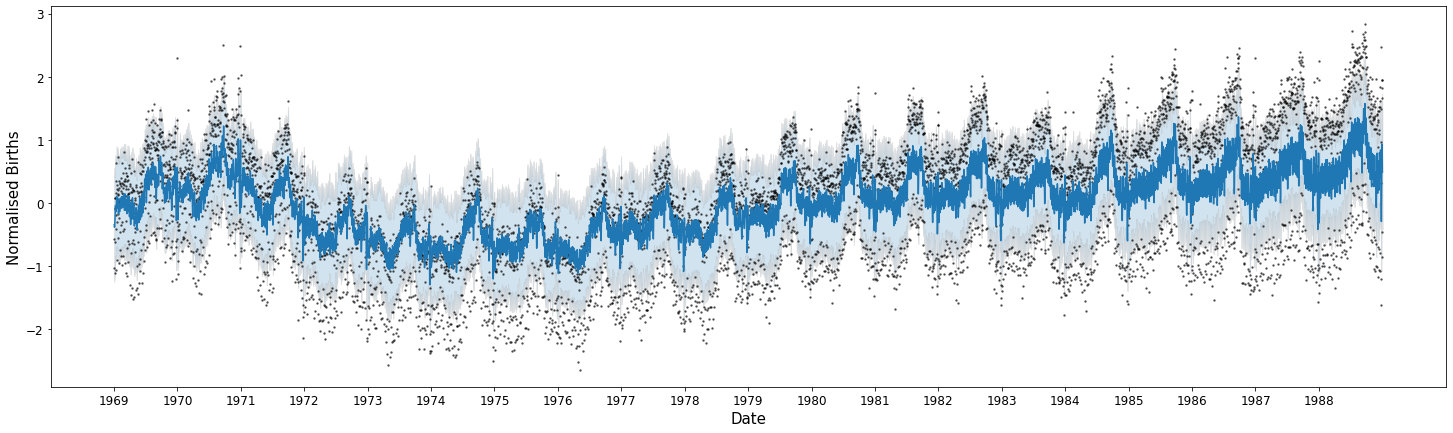

Fitted values MSE:  17790294.27311044
Log-marginal likelihood:  -9778.923317680279


In [9]:
# rebuild model with priors but don't train noise variance

kernel = gpflow.kernels.RBF()

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
set_trainable(model.likelihood.variance , False)

# adding priors
model.kernel.lengthscales.prior = tfp.distributions.Gamma(to_default_float(3), to_default_float(2))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_f(x)

plot_distribution(x, y, mean, var, pos, labels)

print('Fitted values MSE: ', mean_squared_error(x, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())

print_summary(model, fmt='notebook')

Again, similar fitting to the data. Maybe the choice of prior doesn't make much difference.

Investigate how the hyperparameter starting point affects the fitting of the model.

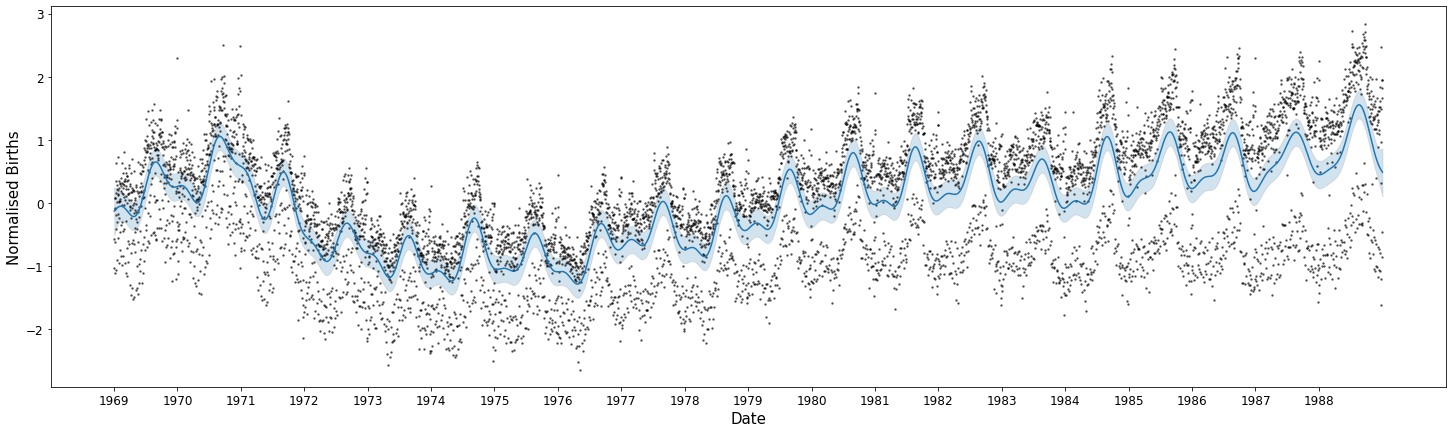

Fitted values MSE:  17789824.775617458
Log-marginal likelihood:  -8920.487536972463


In [32]:
# without priors but different starting conditions

kernel = gpflow.kernels.RBF(lengthscales=5, variance=1)

model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
set_trainable(model.likelihood.variance , False)

# # adding priors
# model.kernel.lengthscales.prior = tfp.distributions.Gamma(to_default_float(3), to_default_float(2))
# model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

mean, var = model.predict_f(x)

plot_distribution(x, y, mean, var, pos, labels)

print('Fitted values MSE: ', mean_squared_error(x, mean))
print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())

print_summary(model, fmt='notebook')

### Sensitivity Analysis

In [27]:
# automate the process

def optimise_predict_model(kernel):
    
    model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
    set_trainable(model.likelihood.variance , False)

    model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(3), to_default_float(2))
    model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
    
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

    mean, var = model.predict_f(x)

    print('Fitted values MSE: ', mean_squared_error(x, mean))
    print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())

    plot_distribution(x, y, mean, var, pos, labels)

    print_summary(model, fmt='notebook')


Starting Values (l,v):  1 1
Fitted values MSE:  17790294.436748754
Log-marginal likelihood:  -9778.926485966329


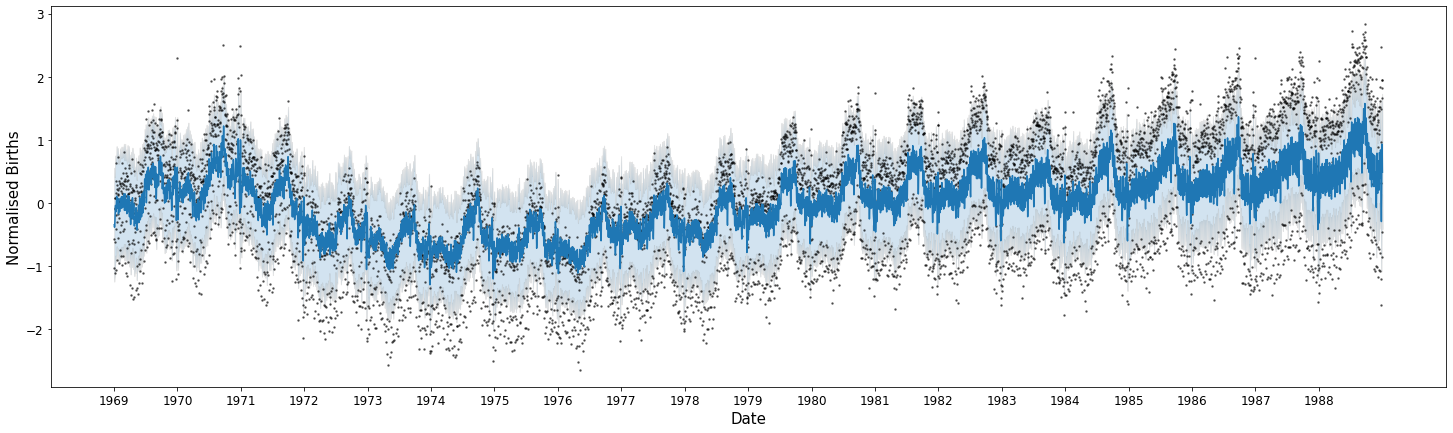

Starting Values (l,v):  1 5
Fitted values MSE:  17789825.419358566
Log-marginal likelihood:  -8920.50760295613


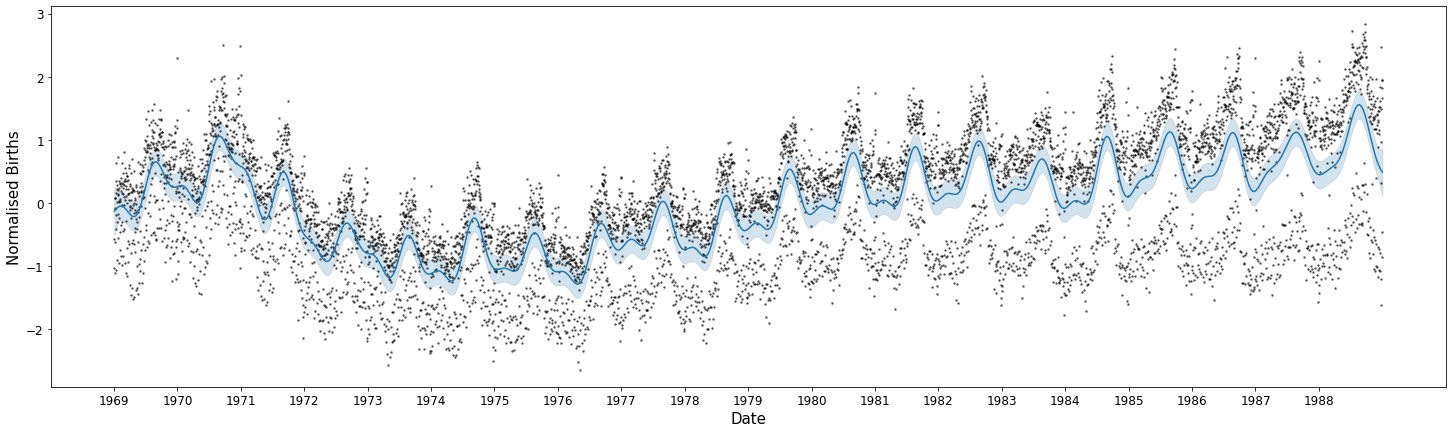

Starting Values (l,v):  5 1
Fitted values MSE:  17789825.419292353
Log-marginal likelihood:  -8920.507604134506


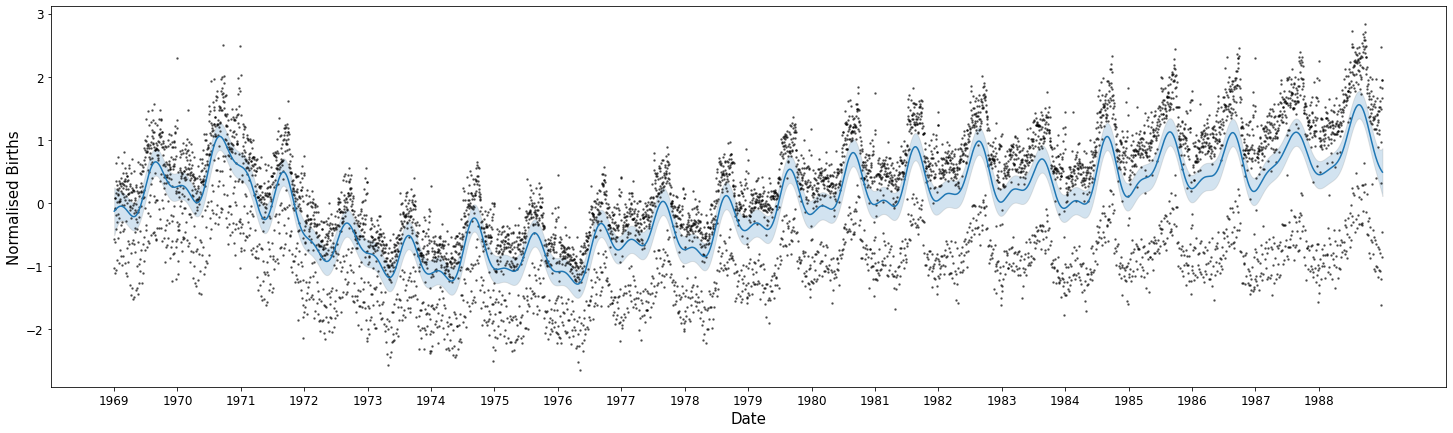

Starting Values (l,v):  5 5
Fitted values MSE:  17789825.42051622
Log-marginal likelihood:  -8920.507713638715


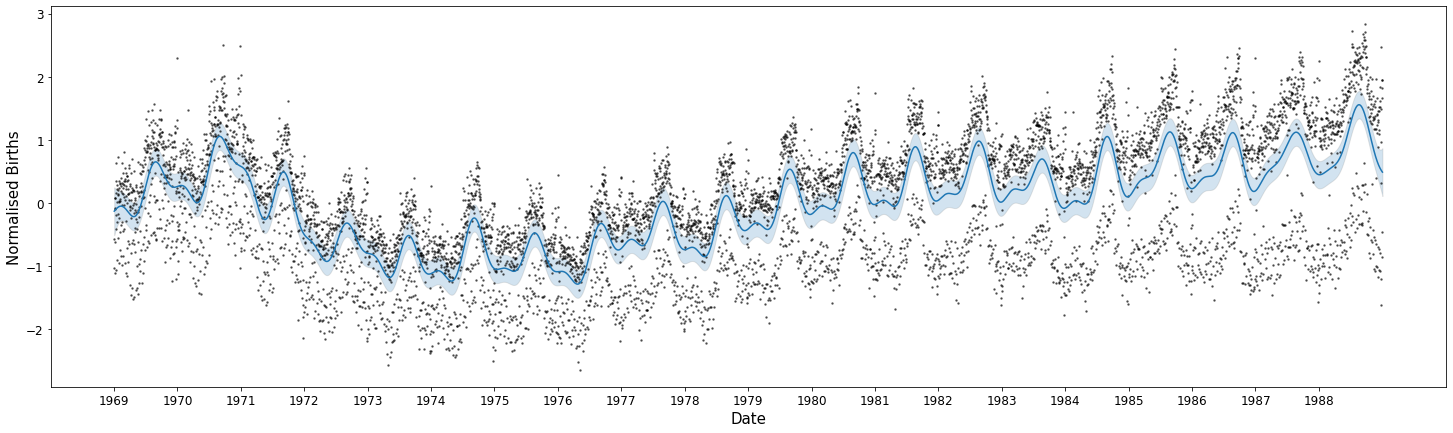

In [28]:
starting_values_l = [1, 5]
starting_values_v = [1, 5]

for l in starting_values_l:
    for v in starting_values_v:
        print('Starting Values (l,v): ', l, v)
        kernel = gpflow.kernels.RBF(lengthscales = l, variance = v)
        optimise_predict_model(kernel)


So FOR THE RBF KERNEL we have found 2 local minima: (l,v) -- (73.3, 0.37) & (2.22, 0.37)

-------------------------------------------------------------

# Train / Test split: model selection

Assess which kernel helps represent the data best.

    MSE, MAE, Likelihood

Since we have found that the starting point of kernel parameters affects the fit significantly, we will first select the kernel and then run an analysis to find optimal starting conditions for hyperparameters.

In [33]:
def optimise_predict_model(model):
    print_summary(model, fmt='notebook')
    
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(model.training_loss, model.trainable_variables)

    mean_train, var_train = model.predict_f(x_train)
    mean_test, var_test = model.predict_f(x_test)

    print('Train')
    plot_distribution(x_train, y_train, mean_train, var_train, pos, labels)
    print('Test')
    plot_distribution(x_test, y_test, mean_test, var_test, pos, labels)

    print_summary(model, fmt='notebook')
    print('Log-marginal likelihood: ', model.log_marginal_likelihood().numpy())
    print('train MSE, MAE: ', mean_squared_error(y_train, mean_train), mean_absolute_error(y_train, mean_train))
    print('test MSE, MAE: ', mean_squared_error(y_test, mean_test), mean_absolute_error(y_test, mean_test))

The models consist of a single latent function, untrainable noise variance (justify), hyperparameters with priors.

Train


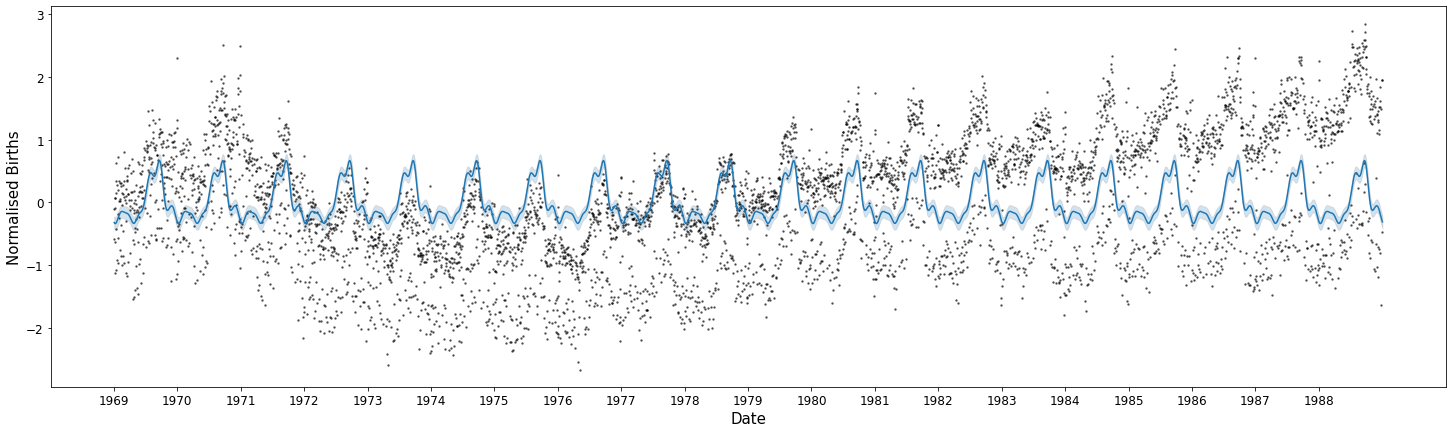

Test


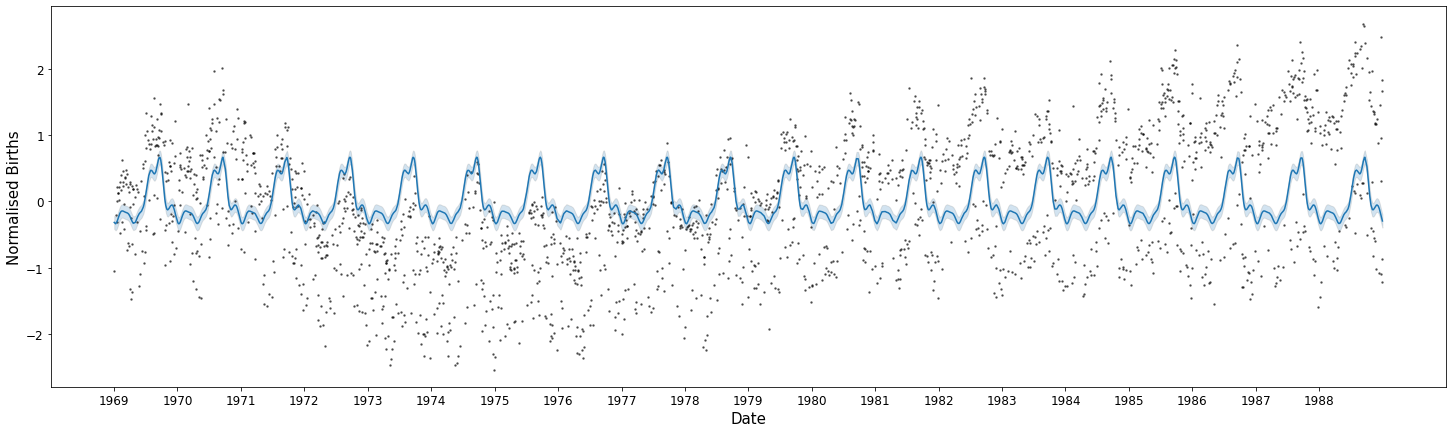

Log-marginal likelihood:  -7041.878549304158
train MSE, MAE:  0.905333094107343 0.8132310034131162
test MSE, MAE:  0.9258847455620339 0.8270656893561908
--------------------------------------------------------


Train


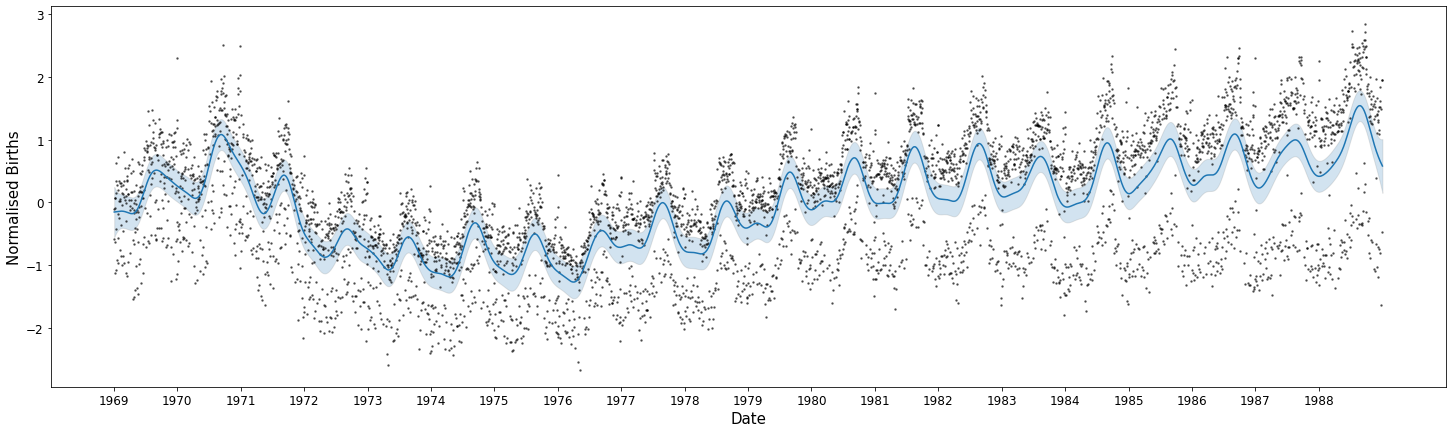

Test


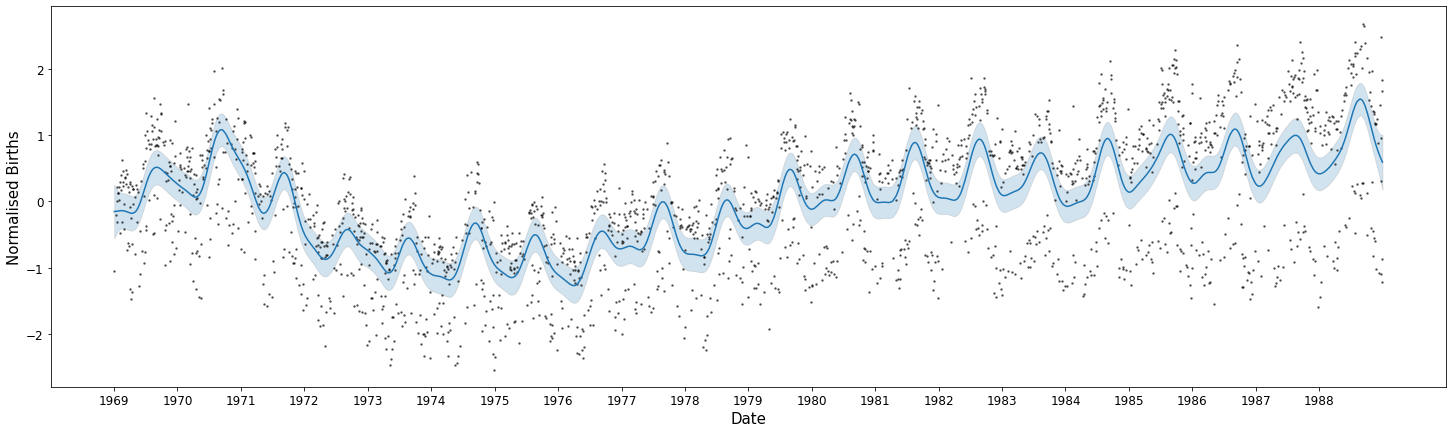

Log-marginal likelihood:  -6276.297162521245
train MSE, MAE:  0.5567476889117577 0.6276987188003368
test MSE, MAE:  0.5925790966306137 0.6476583988878637
--------------------------------------------------------


Train


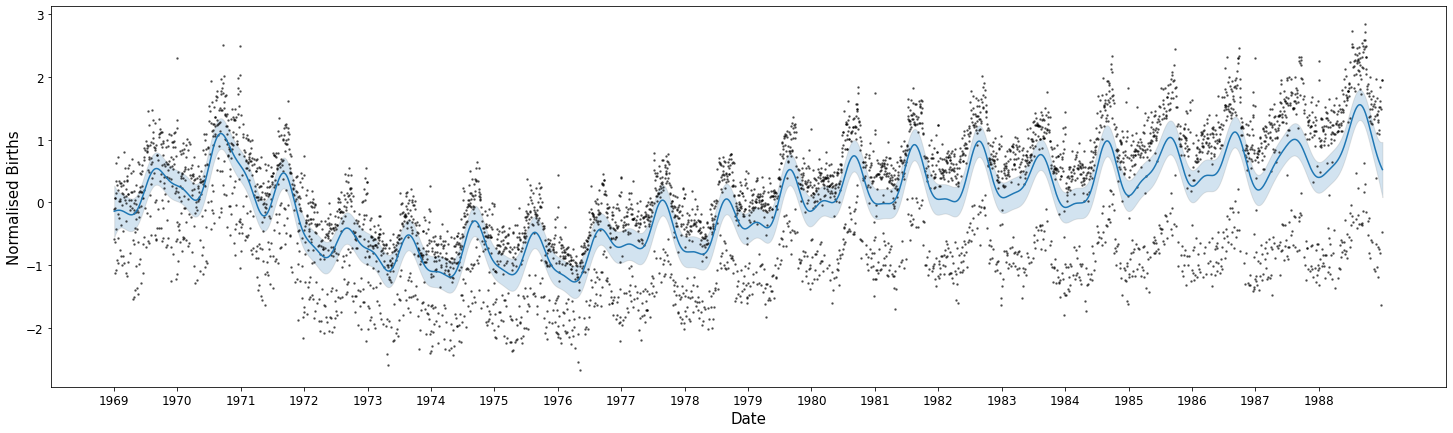

Test


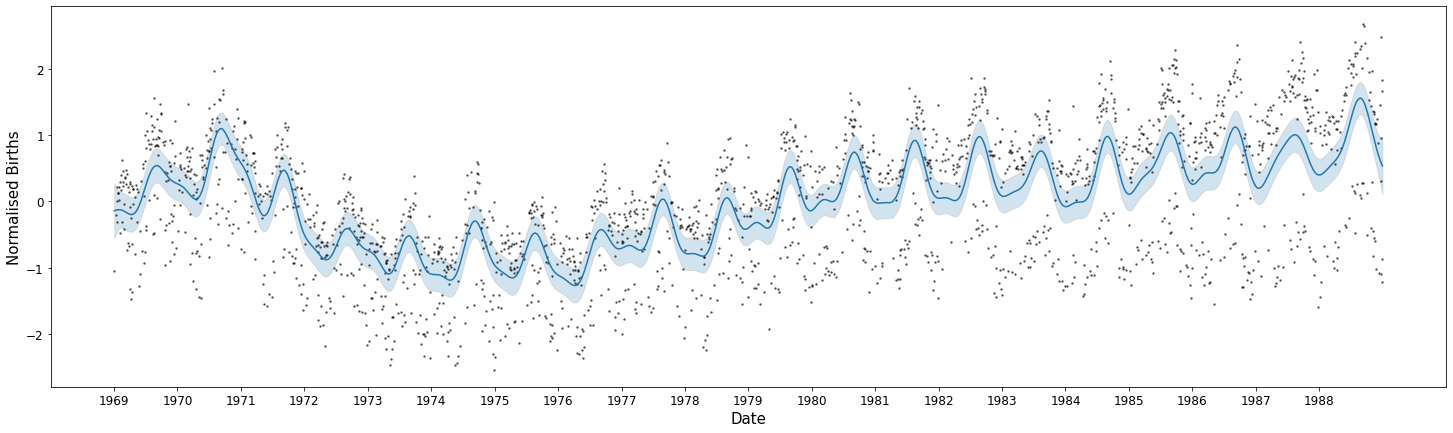

Log-marginal likelihood:  -6278.346791485241
train MSE, MAE:  0.5554130683799028 0.6272626240337699
test MSE, MAE:  0.5899568993756427 0.6464178438117436
--------------------------------------------------------


In [19]:
# Kernel MODEL SELECTION
kernel_list = [gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25), gpflow.kernels.Matern52(), gpflow.kernels.RBF()]

for i in range(len(kernel_list)):
    print(kernel_list[i])

    kernel = kernel_list[i]

    model = gpflow.models.GPR(data=(x_train, y_train), kernel=kernel, mean_function=None)
    set_trainable(model.likelihood.variance , False)

    print_summary(model, fmt='notebook')

    if i == 0:
        set_trainable(model.kernel.period, False)
        model.kernel.base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(3), to_default_float(2))
        model.kernel.base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
    else:
        model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(3), to_default_float(2))
        model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
    
    optimise_predict_model(model)
    print('--------------------------------------------------------')

The kernel with best performance: RBF. Although, Matern52 performs the same.

Now, we would carry out the sensitivity analysis done before but on the train test set.

Starting Values (l, v):  1 1


Train


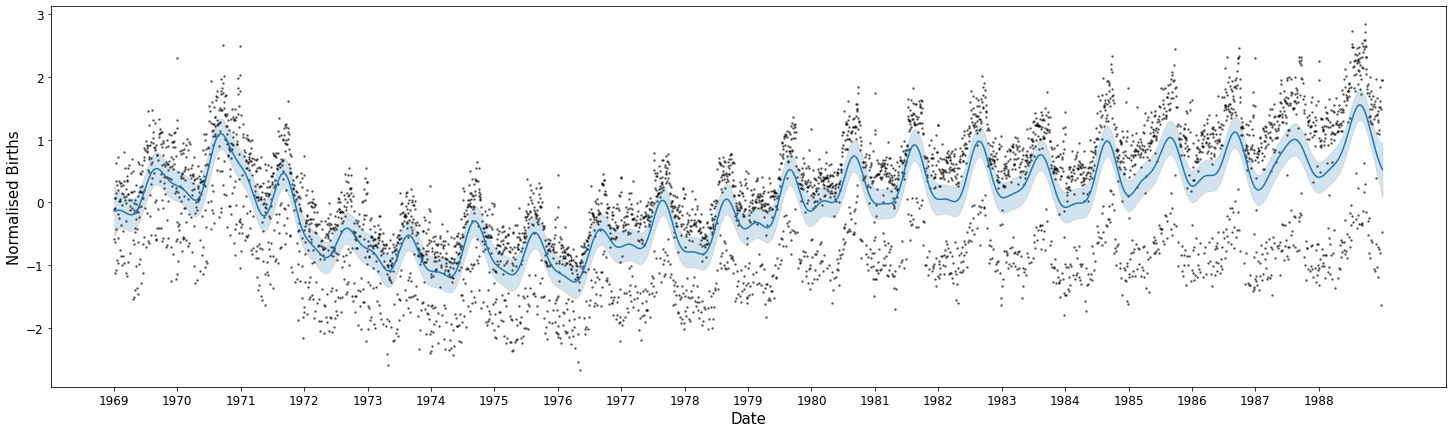

Test


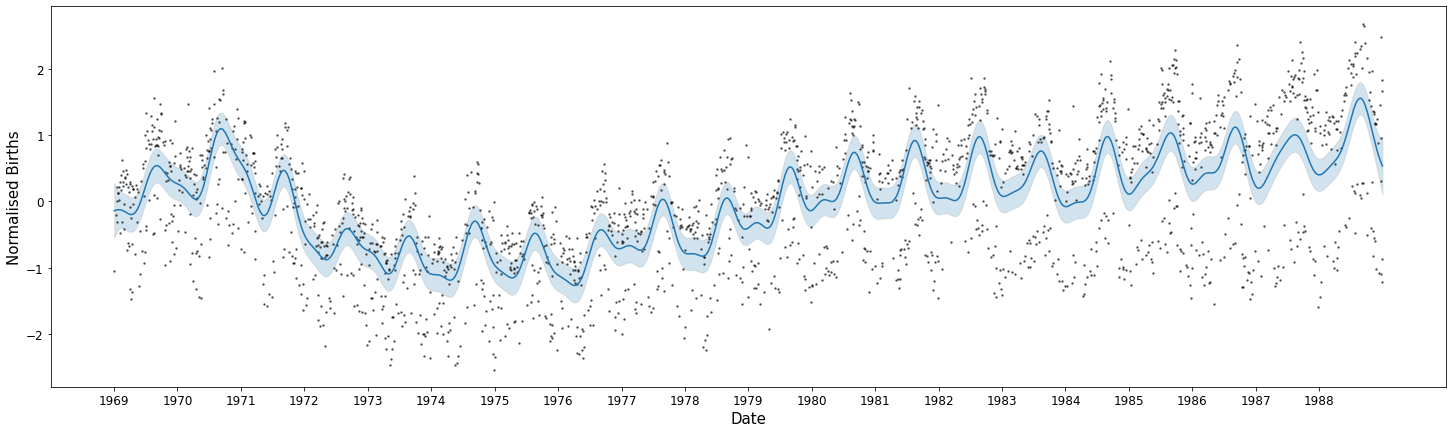

Log-marginal likelihood:  -6278.324355480547
train MSE, MAE:  0.5555975229992463 0.6273335980456
test MSE, MAE:  0.5902115697196988 0.6465391252640982
--------------------------------------------------------
Starting Values (l, v):  5 1


Train


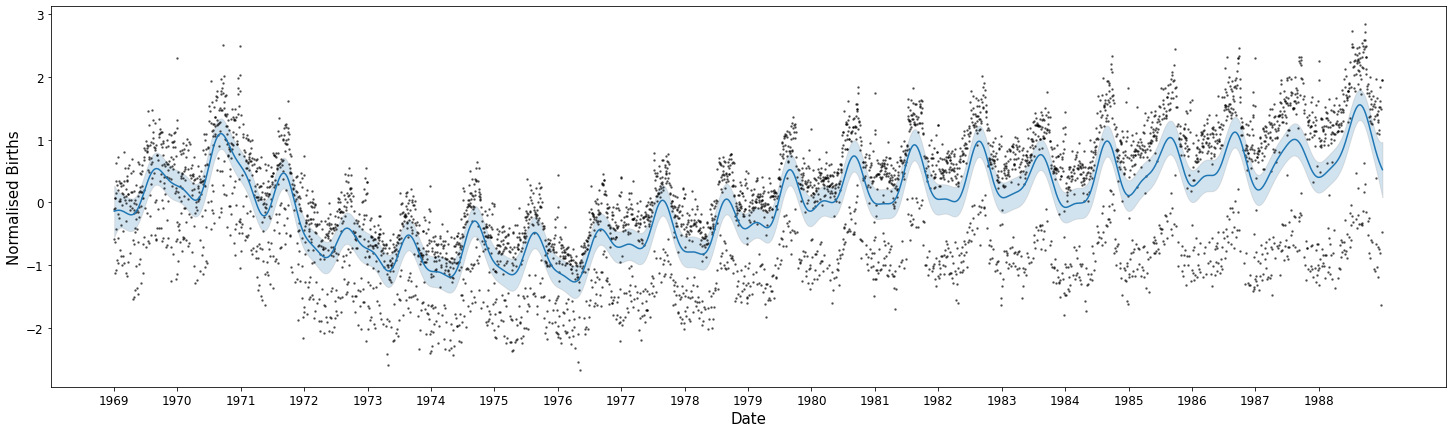

Test


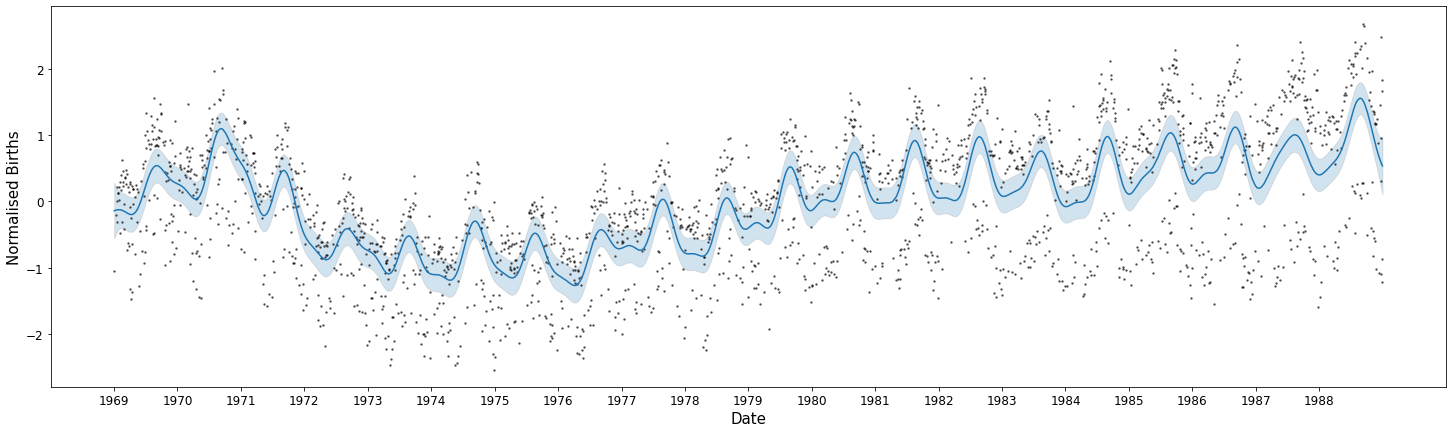

Log-marginal likelihood:  -6278.324253957889
train MSE, MAE:  0.5555982107772203 0.627333824539096
test MSE, MAE:  0.5902126651243472 0.6465396130744907
--------------------------------------------------------


In [34]:
starting_values_l = [1, 5]
starting_values_v = [1]

for l in starting_values_l:
    for v in starting_values_v:
        print('Starting Values (l, v): ', l, v)
        kernel = gpflow.kernels.RBF(lengthscales = l, variance = v)
        model = gpflow.models.GPR(data=(x_train, y_train), kernel=kernel, mean_function=None)
        set_trainable(model.likelihood.variance , False)
        
        model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(0.5), to_default_float(1))
        model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

        optimise_predict_model(model)
        print('--------------------------------------------------------')

There is no difference in the fit when using different starting conditions. 

Why is this the case in the train/test experiment but not so in the case where we work with the whole dataset ???